In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Label distribution 

Total images: 100000


Text(0.5, 1.0, 'Label distribution')

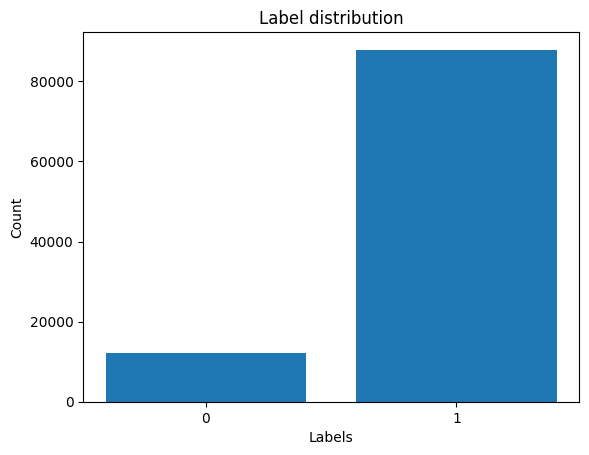

In [2]:
label_file_path = './label_train.txt'
labels = np.loadtxt(label_file_path, dtype=int)

# Define the directory where images are stored
image_dir = './train_img/'

# Get a list of image file names
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# Check if the number of labels matches the number of images
assert len(labels) == len(image_files), "Mismatch between labels and images."

# Print basic statistics
print(f"Total images: {len(image_files)}")
unique_labels, counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, counts)
plt.xticks(unique_labels)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label distribution")

# Just exploring random images to see what are we dealing with

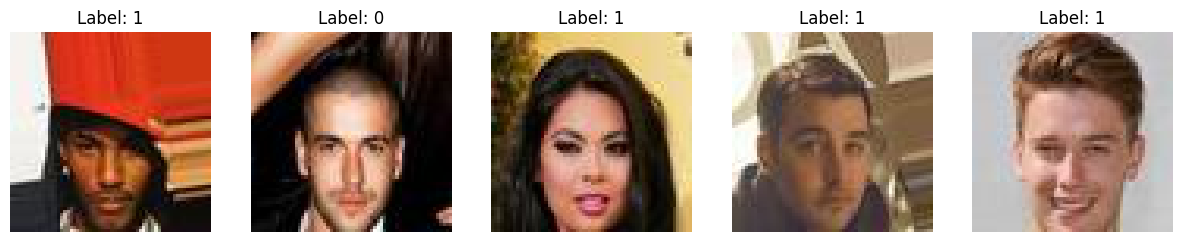

In [3]:
# Load and display a few images with their labels
def show_images(image_files, labels, image_dir, num_images=5):
    plt.figure(figsize=(15, 5))

    random_indices = np.random.choice(list(range(len(image_files))), num_images)
    
    for j, i in enumerate(random_indices):
        img_path = os.path.join(image_dir, image_files[i])
        img = Image.open(img_path)
        plt.subplot(1, num_images, j + 1)
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# Show a few sample images
show_images(image_files, labels, image_dir, num_images=5)

## Can't seem to figure out what are we classifying exactly

Gonna group them to try to identify what's common in each group.

In [4]:
import seaborn as sns
from PIL import Image
import random

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid", palette="muted")

# Create a DataFrame to pair images with their labels
df = pd.DataFrame({'file_name': image_files, 'label': labels})

# Function to display images in two groups: one for each label
def plot_grouped_images(df, image_dir, n=5):
    labels_unique = df['label'].unique()
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    
    for i, label in enumerate(labels_unique):
        # Select random n images for each label
        label_df = df[df['label'] == label].sample(n=n)
        
        for j, (index, row) in enumerate(label_df.iterrows()):
            img_path = os.path.join(image_dir, row['file_name'])
            img = Image.open(img_path)
            ax = axes[i, j]
            ax.imshow(img)
            ax.set_title(f"Label: {label}", fontsize=10)
            ax.axis('off')
            # Add a border around the image
            for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.5)
    
    # Add titles for the groups
    axes[0, 0].set_ylabel("Label 0", fontsize=14, weight='bold')
    axes[1, 0].set_ylabel("Label 1", fontsize=14, weight='bold')

    # Add a title to the entire plot
    plt.suptitle("Comparison of Images by Label", fontsize=18, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


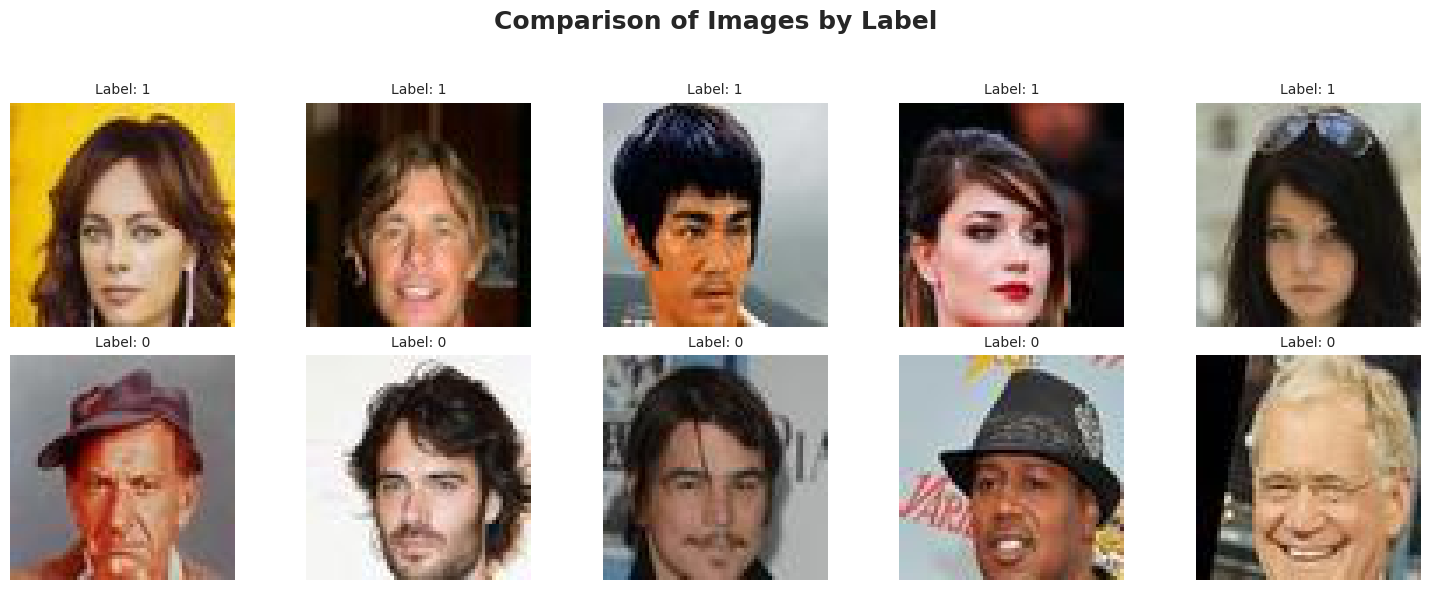

In [5]:
# Display n random images from each label, side by side
plot_grouped_images(df, image_dir, n=5)

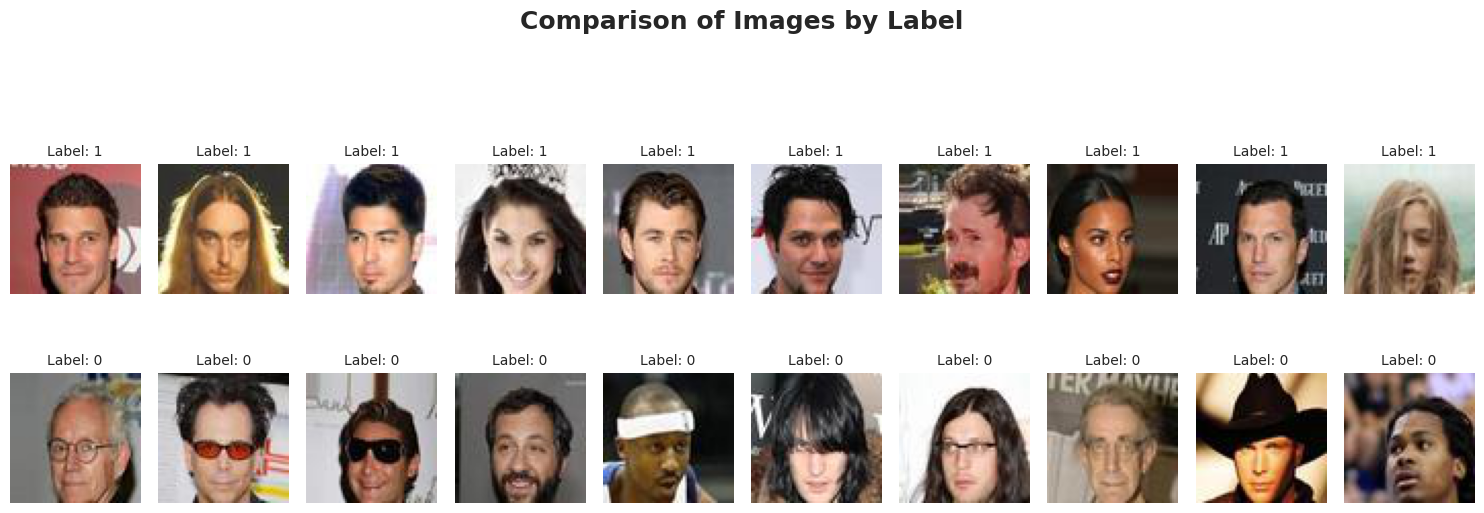

In [6]:
# Display n random images from each label, side by side
plot_grouped_images(df, image_dir, n=10)

In both classes, the images contain portraits of various individuals with diverse characteristics:

- Different genders
- Various hair colors and styles
- Different ethnicities
- Some wearing glasses, some not
- Some smiling, some with more neutral expressions
- Different backgrounds and lighting conditions

In [7]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report

def analyze_image_stats(image_folder, label_file):
    labels = np.loadtxt(label_file, dtype=int)
    stats = []
    
    for i, filename in enumerate(os.listdir(image_folder)):
        img = Image.open(os.path.join(image_folder, filename)).convert('RGB')
        img_array = np.array(img)
        
        stats.append([
            np.mean(img_array),
            np.std(img_array),
            np.mean(img_array[:,:,0]),  # Red channel mean
            np.mean(img_array[:,:,1]),  # Green channel mean
            np.mean(img_array[:,:,2]),  # Blue channel mean
        ])
    
    stats = np.array(stats)
    
    for i in range(stats.shape[1]):
        print(f"Feature {i} correlation with label: {np.corrcoef(stats[:,i], labels)[0,1]}")
    
    # Simple threshold-based classifier
    predictions = (stats[:,0] > np.mean(stats[:,0])).astype(int)
    print(classification_report(labels, predictions))

analyze_image_stats('train_img/', 'label_train.txt')

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def analyze_color_histograms(image_folder, label_file):
    labels = np.loadtxt(label_file, dtype=int)
    features = []

    for i, filename in enumerate(os.listdir(image_folder)):
        img = cv2.imread(os.path.join(image_folder, filename))
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        features.append(hist.flatten())

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))

analyze_color_histograms('train_img', 'label_train.txt')

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def analyze_image_segments(image_folder, label_file, n_segments=5):
    labels = np.loadtxt(label_file, dtype=int)
    features = []

    for i, filename in enumerate(os.listdir(image_folder)):
        img = cv2.imread(os.path.join(image_folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape((-1, 3))
        
        kmeans = KMeans(n_clusters=n_segments, random_state=42)
        kmeans.fit(img)
        
        hist, _ = np.histogram(kmeans.labels_, bins=n_segments)
        features.append(hist / np.sum(hist))

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))

analyze_image_segments('train_img', 'label_train.txt')

In [ ]:
import cv2
import numpy as np
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def image_entropy(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    return entropy(hist, base=2)

def analyze_image_entropy(image_folder, label_file):
    labels = np.loadtxt(label_file, dtype=int)
    features = []

    for i, filename in enumerate(os.listdir(image_folder)):
        img = cv2.imread(os.path.join(image_folder, filename))
        features.append([image_entropy(img)])

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))

analyze_image_entropy('train_img', 'label_train.txt')